In [1]:
# Core
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

# Machine Learning - Preprocessing & Modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Association Rule Mining
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from unidecode import unidecode
from mlxtend.preprocessing import TransactionEncoder


In [3]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('AA_movie_train_data.csv')

In [5]:
df.head()

,Title,Genre,Description
0,Windup (2006),action,Windup is a very original comedy. We follow B...
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...


In [6]:
df['Genre'].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
drama          1000
thriller       1000
Name: count, dtype: int64

In [7]:
df['Description'][0]

' Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick\'s life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn\'t get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie\'s girlfriend Latrice and roommate Stuart only accentuate Bernie\'s seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie becau

In [8]:
def get_stop_words(stop_file_path, include_spanish=True):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    if include_spanish:
        spanish_stopwords = set(nltk_stopwords.words('spanish'))
        custom_stopwords.update(spanish_stopwords)
    
    return frozenset(custom_stopwords)

In [9]:
def clean_text(text):
    text = unidecode(text)                     # strip accents
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [10]:
def tokenize_text(text):
    return word_tokenize(text)

In [11]:
def get_wordnet_pos(treebank_tag):
    """Convert TreeBank POS tags to WordNet POS tags"""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


In [12]:
def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  # You already have this function
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas

In [13]:
stopwords = get_stop_words("stopwords.txt", include_spanish=True)

# 🔹 3. Full processing pipeline function
def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)

# 🔹 4. Apply to DataFrame
# Apply function and unpack results
df[['description_tokens', 'description_string']] = df['Description'].apply(
    lambda x: pd.Series(full_text_pipeline(x, stopwords))
)

description_tokens = df['description_tokens'].apply(len)
description_string = df['description_string']
df[['description_string']].to_csv('processed_descriptions.csv', index=False)

In [14]:
average_tokens = description_tokens.mean()
average_tokens

68.1758

In [15]:
description_string[0]

'windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gra

In [16]:
description_string.shape

(5000,)

In [17]:
bow_vectorizer = CountVectorizer(max_df=0.16, max_features=5000)
description_bow_matrix = bow_vectorizer.fit_transform(description_string.tolist())

In [18]:
sum_words = description_bow_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [19]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('woman', 1110),
 ('people', 962),
 ('kill', 945),
 ('try', 903),
 ('own', 900),
 ('father', 886),
 ('girl', 879),
 ('leave', 847),
 ('meet', 824),
 ('help', 798),
 ('home', 762),
 ('mother', 755),
 ('wife', 741),
 ('begin', 713),
 ('start', 696),
 ('death', 673),
 ('brother', 670),
 ('police', 663),
 ('city', 659),
 ('lead', 655)]

In [20]:
print('The lowest frequency words:')
words_freq[-20:] 

The lowest frequency words:


[('translate', 10),
 ('thinker', 10),
 ('suppress', 10),
 ('tango', 10),
 ('rosario', 10),
 ('definition', 10),
 ('epidemic', 10),
 ('mississippi', 10),
 ('uber', 10),
 ('loop', 10),
 ('ruling', 10),
 ('depiction', 10),
 ('mohawk', 10),
 ('fatherhood', 10),
 ('manor', 10),
 ('concentration', 10),
 ('mick', 10),
 ('tibet', 10),
 ('toi', 10),
 ('agatha', 10)]

In [21]:
bow_vectorizer.get_feature_names_out()

array(['aaron', 'aarti', 'abandon', ..., 'zombie', 'zone', 'zorawar'],
      dtype=object)

In [22]:
feature_names=np.array(bow_vectorizer.get_feature_names_out())
len(bow_vectorizer.get_feature_names_out())

5000

In [23]:
pd.DataFrame(description_bow_matrix.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_bow = pd.DataFrame(description_bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
df_bow.to_csv('asg1_bow_export.csv', index=False)

### 1.4 TF-IDF

In [25]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
description_tfidf = tfidf_transformer.fit_transform(description_bow_matrix)

In [26]:
tfidf_transformer.idf_

array([7.1194979 , 7.7256337 , 4.68111126, ..., 5.56614945, 6.29851735,
       8.82424599])

In [27]:
tfidf_transformer.idf_.shape

(5000,)

In [28]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['own' 'woman' 'try' 'people' 'meet' 'leave' 'help' 'kill' 'begin' 'start'
 'home' 'father' 'decide' 'lead' 'girl' 'follow' 'force' 'look' 'wife'
 'death' 'set' 'name' 'tell' 'bring' 'mother' 'city' 'soon' 'run' 'fall'
 'call' 'fight' 'child' 'daughter' 'police' 'return' 'change' 'night'
 'brother' 'discover' 'town' 'murder' 'lose' 'local' 'house' 'past'
 'documentary' 'secret' 'learn' 'plan' 'play' 'school' 'move' 'dream'
 'job' 'journey' 'save' 'series' 'money' 'happen' 'struggle'
 'relationship' 'movie' 'include' 'real' 'country' 'escape' 'war' 'hand'
 'head' 'die' 'win' 'character' 'event' 'american' 'attempt' 'realize'
 'break' 'sister' 'boy' 'husband' 'dead' 'student' 'stop' 'bad' 'power'
 'human' 'age' 'team' 'true' 'little' 'question' 'experience' 'former'
 'create' 'search' 'evil' 'believe' 'drug' 'beautiful' 'hold']


In [29]:
pd.DataFrame(description_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# find maximum value for each of the features over dataset:
max_value = description_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['praise' 'pound' 'tease' 'dire' 'endanger' 'obsessive' 'conceal' 'injure'
 'kapoor' 'operate' 'seriously' 'thirsty' 'dc' 'actually' 'flees'
 'resemble' 'enthusiasm' 'flip' 'seventeen' 'verma']
Features with highest tfidf: 
['jo' 'shanichari' 'kishan' 'coral' 'jaggu' 'yoga' 'jaswant' 'devin' 'di'
 'perry' 'volcano' 'pierre' 'sreeram' 'rider' 'selma' 'laundry' 'wine'
 'juan' 'comme' 'mar']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [31]:
idx=0
doc = description_string[idx]
print(doc)

tf_idf_vector=description_tfidf[idx]
print(tf_idf_vector)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [32]:
tf_idf_vector.shape

(1, 5000)

In [33]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

,feature_number,tf_idf
0,58,0.032735
1,146,0.033600
2,252,0.047520
3,322,0.172975
4,401,0.042489
...,...,...
95,4747,0.041597
96,4889,0.098373
97,4897,0.044398
98,4949,0.065587


In [34]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

,feature_number,tf_idf
5,430,0.853499
3,322,0.172975
93,4672,0.144446
74,3599,0.103692
88,4288,0.101146
...,...,...
52,2572,0.024936
19,1099,0.023812
37,1761,0.022122
39,1895,0.022085


In [35]:
#use only topn items from vector
topn = 15
topn_items = temp[:topn]

tf_idf = []
word = []

for index, row in topn_items.iterrows():
    fname = feature_names[int(row['feature_number'])]
    word.append(fname)
    tf_idf.append(round(row['tf_idf'], 3))    

In [36]:
print(doc, '\n')

result = dict(zip(word, tf_idf))
print(result)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [37]:
topn = 15
results =[]

In [38]:
for idx, doc in description_string.items():
    #generate tf-idf for the given document
    tf_idf_vector=description_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    
    results.append(result)


In [39]:
len(results)

5000

In [40]:
df['keywords'] = results
df.head()

,Title,Genre,Description,description_tokens,description_string,keywords
0,Windup (2006),action,Windup is a very original comedy. We follow B...,"[windup, original, comedy, follow, bernie, sha...",windup original comedy follow bernie shaddick ...,"{'bernie': 0.853, 'aunt': 0.173, 'uncle': 0.14..."
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ...","[rana, shuvo, sibling, father, police, constab...",rana shuvo sibling father police constable dea...,"{'rana': 0.677, 'brother': 0.224, 'crime': 0.1..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...,"[san, francisco, detective, hunt, cruel, asian...",san francisco detective hunt cruel asian crime...,"{'nelson': 0.542, 'violent': 0.222, 'detective..."
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i...","[name, lam, pick, girlfriend, reveal, girlfrie...",name lam pick girlfriend reveal girlfriend act...,"{'lam': 0.744, 'gangster': 0.386, 'martial': 0..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...,"[thap, homeless, musician, brother, village, r...",thap homeless musician brother village raid kh...,"{'ram': 0.768, 'prince': 0.34, 'kingdom': 0.23..."


In [41]:
# Extract only the keyword keys from the dictionary (ignore TF-IDF values)
token_lists = df['keywords'].apply(lambda x: list(x.keys()))

# Convert to DataFrame, automatically expands lists into columns
transactions_df = pd.DataFrame(token_lists.tolist())

# Save to CSV without index or header
transactions_df.to_csv('transactions.csv', index=False, header=False)


### 2.2 Association Rules Mining on keywords

In [42]:
transactions = pd.read_csv("transactions.csv", header=None)
transactions.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,bernie,aunt,uncle,real,stuart,welfare,cuban,invent,mentor,product,commercial,pose,estate,co,worker
1,rana,brother,crime,bravery,extent,police,shower,tall,tackle,promote,villain,arise,assume,sibling,brave
2,nelson,violent,detective,asian,francisco,device,san,terrorist,center,capture,partner,steal,gang,art,triad
3,lam,gangster,martial,artist,girlfriend,brother,kill,furious,fight,trap,reveal,stab,protection,guilty,lay
4,ram,prince,kingdom,village,plan,residence,stir,raid,villager,meet,frame,homeless,musician,determine,justice


In [43]:
transactions = [list(d.keys()) for d in results]
print(transactions)

[['bernie', 'aunt', 'uncle', 'real', 'stuart', 'welfare', 'cuban', 'invent', 'mentor', 'product', 'commercial', 'pose', 'estate', 'co', 'worker'], ['rana', 'brother', 'crime', 'bravery', 'extent', 'police', 'shower', 'tall', 'tackle', 'promote', 'villain', 'arise', 'assume', 'sibling', 'brave'], ['nelson', 'violent', 'detective', 'asian', 'francisco', 'device', 'san', 'terrorist', 'center', 'capture', 'partner', 'steal', 'gang', 'art', 'triad'], ['lam', 'gangster', 'martial', 'artist', 'girlfriend', 'brother', 'kill', 'furious', 'fight', 'trap', 'reveal', 'stab', 'protection', 'guilty', 'lay'], ['ram', 'prince', 'kingdom', 'village', 'plan', 'residence', 'stir', 'raid', 'villager', 'meet', 'frame', 'homeless', 'musician', 'determine', 'justice'], ['ninja', 'diamond', 'smuggler', 'pose', 'assault', 'thug', 'trio', 'rap', 'dealer', 'wood', 'wait', 'beat', 'justice', 'hunt', 'sell'], ['humanity', 'globe', 'terrorist', 'understand', 'enemy', 'attack', 'turkey', 'bring', 'psyche', 'terroris

In [44]:
# Assuming df['keywords'] contains dictionaries
transactions = df['keywords'].apply(lambda x: list(x.keys())).tolist()

# Now transactions is a list of lists of strings
te = TransactionEncoder()
data_encoded = te.fit_transform(transactions)

# Convert to DataFrame
data_encoded_df = pd.DataFrame(data_encoded, columns=te.columns_)

# Check shape
print(data_encoded_df.shape)


(5000, 5000)


In [45]:
# Step 1: Calculate total frequency of each keyword across all transactions
keyword_counts = data_encoded_df.sum().sort_values(ascending=False)

# Step 2: Select top 200 keywords
top_keywords = keyword_counts.head(100).index

# Step 3: Filter the encoded DataFrame to include only these columns
data_encoded_filtered = data_encoded_df[top_keywords]


In [46]:
print(data_encoded.sum(axis=1).mean())

14.9724


In [47]:
data_encoded_filtered.shape

(5000, 100)

In [48]:
data_encoded_filtered

,girl,father,brother,woman,mother,kill,school,police,wife,child,...,guy,ghost,jack,look,music,follow,officer,detective,lead,zombie
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [49]:
for support in [0.05, 0.01, 0.005, 0.003, 0.002]:
    itemsets = apriori(data_encoded_filtered, min_support=support, use_colnames=True)
    print(f"Support: {support}, Itemsets: {itemsets.shape[0]}")

Support: 0.05, Itemsets: 0
Support: 0.01, Itemsets: 64
Support: 0.005, Itemsets: 100
Support: 0.003, Itemsets: 105
Support: 0.002, Itemsets: 118


In [50]:
frequent_itemsets=apriori(data_encoded_filtered, min_support = 0.002, use_colnames = True)

In [51]:
frequent_itemsets[['support']].describe()

,support
count,118.000000
mean,0.011300
std,0.006085
min,0.002000
25%,0.008200
50%,0.010200
75%,0.013750
max,0.029200


In [52]:
frequent_itemsets

,support,itemsets
0,0.0292,(girl)
1,0.0286,(father)
2,0.0266,(brother)
3,0.0264,(woman)
4,0.0254,(mother)
...,...,...
113,0.0034,"(officer, police)"
114,0.0026,"(daughter, wife)"
115,0.0020,"(husband, wife)"
116,0.0024,"(murder, killer)"


In [53]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(school),(girl),0.0234,0.0292,0.0026,0.111111,3.805175,1.0,0.001917,1.092150,0.754864,0.052000,0.084375,0.100076
1,(girl),(school),0.0292,0.0234,0.0026,0.089041,3.805175,1.0,0.001917,1.072057,0.759374,0.052000,0.067214,0.100076
2,(brother),(father),0.0266,0.0286,0.0024,0.090226,3.154740,1.0,0.001639,1.067737,0.701681,0.045455,0.063440,0.087071
3,(father),(brother),0.0286,0.0266,0.0024,0.083916,3.154740,1.0,0.001639,1.062566,0.703126,0.045455,0.058882,0.087071
4,(father),(mother),0.0286,0.0254,0.0032,0.111888,4.405044,1.0,0.002474,1.097384,0.795746,0.062992,0.088742,0.118936
5,(mother),(father),0.0254,0.0286,0.0032,0.125984,4.405044,1.0,0.002474,1.111422,0.793133,0.062992,0.100251,0.118936
6,(father),(daughter),0.0286,0.0188,0.0020,0.069930,3.719685,1.0,0.001462,1.054974,0.752687,0.044053,0.052110,0.088157
7,(daughter),(father),0.0188,0.0286,0.0020,0.106383,3.719685,1.0,0.001462,1.087043,0.745169,0.044053,0.080073,0.088157
8,(brother),(kill),0.0266,0.0246,0.0024,0.090226,3.667706,1.0,0.001746,1.072134,0.747226,0.049180,0.067281,0.093893
9,(kill),(brother),0.0246,0.0266,0.0024,0.097561,3.667706,1.0,0.001746,1.078632,0.745694,0.049180,0.072900,0.093893


In [54]:
# Option B
rules_l[ (rules_l['lift'] >= 1.5) &
       (rules_l['confidence'] >= 0.1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(school),(girl),0.0234,0.0292,0.0026,0.111111,3.805175,1.0,0.001917,1.092150,0.754864,0.052000,0.084375,0.100076
4,(father),(mother),0.0286,0.0254,0.0032,0.111888,4.405044,1.0,0.002474,1.097384,0.795746,0.062992,0.088742,0.118936
5,(mother),(father),0.0254,0.0286,0.0032,0.125984,4.405044,1.0,0.002474,1.111422,0.793133,0.062992,0.100251,0.118936
7,(daughter),(father),0.0188,0.0286,0.0020,0.106383,3.719685,1.0,0.001462,1.087043,0.745169,0.044053,0.080073,0.088157
12,(daughter),(mother),0.0188,0.0254,0.0020,0.106383,4.188306,1.0,0.001522,1.090624,0.775826,0.047393,0.083094,0.092562
14,(kill),(police),0.0246,0.0232,0.0040,0.162602,7.008691,1.0,0.003429,1.166470,0.878942,0.091324,0.142713,0.167508
15,(police),(kill),0.0232,0.0246,0.0040,0.172414,7.008691,1.0,0.003429,1.178608,0.877682,0.091324,0.151542,0.167508
17,(wife),(kill),0.0218,0.0246,0.0022,0.100917,4.102335,1.0,0.001664,1.084884,0.773090,0.049774,0.078242,0.095174
18,(killer),(kill),0.0134,0.0246,0.0022,0.164179,6.673947,1.0,0.001870,1.166996,0.861711,0.061453,0.143099,0.126805
21,(inspector),(kill),0.0082,0.0246,0.0024,0.292683,11.897680,1.0,0.002198,1.379014,0.923523,0.078947,0.274844,0.195122


In [55]:
df

,Title,Genre,Description,description_tokens,description_string,keywords
0,Windup (2006),action,Windup is a very original comedy. We follow B...,"[windup, original, comedy, follow, bernie, sha...",windup original comedy follow bernie shaddick ...,"{'bernie': 0.853, 'aunt': 0.173, 'uncle': 0.14..."
1,Hitman (2014),action,"Rana and Shuvo, two siblings, are very differ...","[rana, shuvo, sibling, father, police, constab...",rana shuvo sibling father police constable dea...,"{'rana': 0.677, 'brother': 0.224, 'crime': 0.1..."
2,Taken by Force (2010),action,When a San Francisco detective goes hunting f...,"[san, francisco, detective, hunt, cruel, asian...",san francisco detective hunt cruel asian crime...,"{'nelson': 0.542, 'violent': 0.222, 'detective..."
3,Bui doi Cho Lon (2013),action,"A man name Lam picks up his girlfriend, but i...","[name, lam, pick, girlfriend, reveal, girlfrie...",name lam pick girlfriend reveal girlfriend act...,"{'lam': 0.744, 'gangster': 0.386, 'martial': 0..."
4,Siam Yuth: The Dawn of the Kingdom (2015),action,Thap and Sin are a homeless musician brothers...,"[thap, homeless, musician, brother, village, r...",thap homeless musician brother village raid kh...,"{'ram': 0.768, 'prince': 0.34, 'kingdom': 0.23..."
...,...,...,...,...,...,...
4995,The Harvesters (2000),thriller,Danielle Carver has inherited the same heart ...,"[danielle, carver, inherit, heart, disease, mo...",danielle carver inherit heart disease mother d...,"{'danielle': 0.517, 'rachel': 0.448, 'jeff': 0..."
4996,PRND (2017),thriller,When Max has a disturbing incident with a dri...,"[max, disturbing, incident, driver, transporta...",max disturbing incident driver transportation ...,"{'max': 0.594, 'driver': 0.364, 'car': 0.204, ..."
4997,Jimmy Tupper vs. the Goatman of Bowie (2010),thriller,"Jimmy Tupper is a no one, he's nothing. He sp...","[jimmy, tupper, spend, day, starbucks, suburba...",jimmy tupper spend day starbucks suburban mary...,"{'jimmy': 0.689, 'wood': 0.305, 'monster': 0.2..."
4998,Captive of a Death Mask (2012),thriller,The only one more scared than his victims is ...,"[scar, victim, killer, underground, fighter, p...",scar victim killer underground fighter porter ...,"{'victim': 0.264, 'killer': 0.249, 'die': 0.23..."


# DONT LOOK BELOW

# BOW MODELLING

In [98]:
X = description_bow_matrix
y = df["Genre"].values

In [99]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


# BEFORE TRAINING

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔵 Logistic Regression Report")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))
f1_log = f1_score(y_test, y_pred_log, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_log:.4f}")

🔵 Logistic Regression Report
              precision    recall  f1-score   support

      action       0.73      0.70      0.71       316
      comedy       0.59      0.59      0.59       309
 documentary       0.73      0.80      0.76       284
       drama       0.55      0.56      0.56       301
    thriller       0.73      0.69      0.71       290

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.66      1500

🎯 Weighted F1 Score: 0.6650


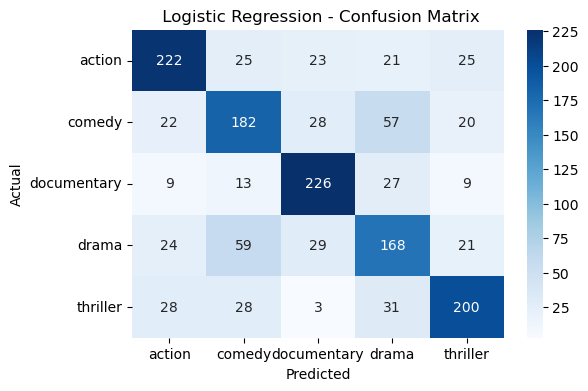

In [102]:
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [103]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🟢 Random Forest Report")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_rf:.4f}")


🟢 Random Forest Report
              precision    recall  f1-score   support

      action       0.63      0.67      0.65       316
      comedy       0.67      0.48      0.56       309
 documentary       0.70      0.85      0.77       284
       drama       0.52      0.58      0.55       301
    thriller       0.67      0.60      0.64       290

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.63      1500
weighted avg       0.64      0.64      0.63      1500

🎯 Weighted F1 Score: 0.6313


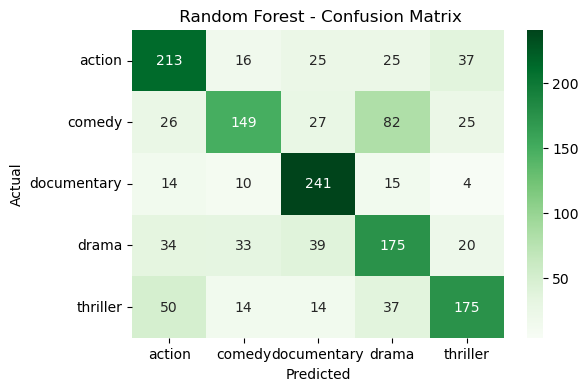

In [104]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [105]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("🟡 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_nb:.4f}")

🟡 Naive Bayes Report
              precision    recall  f1-score   support

      action       0.75      0.69      0.72       316
      comedy       0.66      0.59      0.63       309
 documentary       0.71      0.86      0.78       284
       drama       0.54      0.54      0.54       301
    thriller       0.74      0.73      0.73       290

    accuracy                           0.68      1500
   macro avg       0.68      0.68      0.68      1500
weighted avg       0.68      0.68      0.68      1500

🎯 Weighted F1 Score: 0.6779


c:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


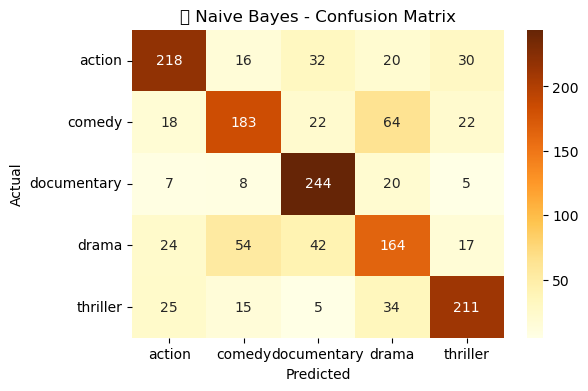

In [106]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("🟡 Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AFTER TRAINING

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Feature selection
selector = SelectKBest(chi2, k=3900)  # you can change k=2000/4000 as needed
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Plotting function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.72      0.73       300
      comedy       0.65      0.68      0.67       300
 documentary       0.80      0.80      0.80       300
       drama       0.59      0.58      0.59       300
    thriller       0.71      0.70      0.71       300

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Weighted F1 Score: 0.6994


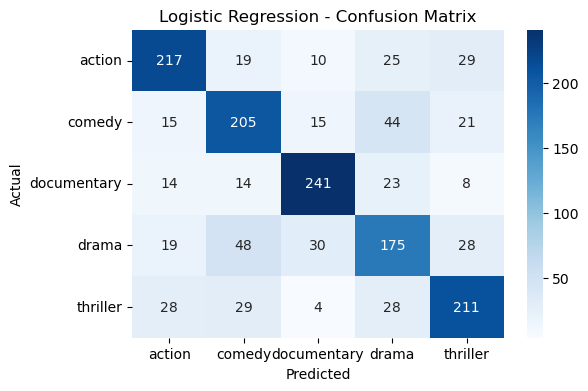

In [162]:
print("🔵 Logistic Regression")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='f1_weighted', cv=5)
grid_lr.fit(X_train_sel, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.68      0.66       300
      comedy       0.65      0.50      0.57       300
 documentary       0.72      0.78      0.75       300
       drama       0.53      0.56      0.55       300
    thriller       0.67      0.71      0.69       300

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.64      1500
weighted avg       0.65      0.65      0.64      1500

🎯 Weighted F1 Score: 0.6429


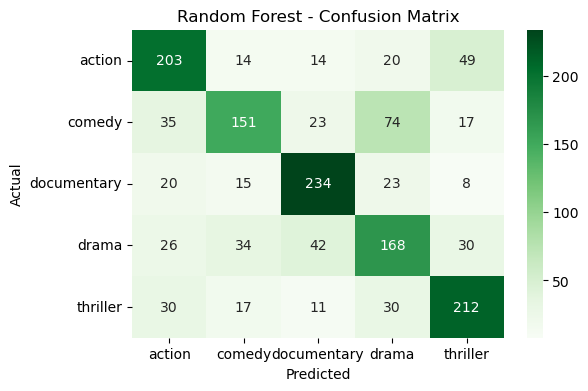

In [142]:
# --- RANDOM FOREST ---

print("🟢 Random Forest")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='f1_weighted', cv=5)
grid_rf.fit(X_train_sel, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_sel)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)


🟡 Naive Bayes
              precision    recall  f1-score   support

      action       0.73      0.68      0.70       300
      comedy       0.67      0.64      0.66       300
 documentary       0.73      0.82      0.77       300
       drama       0.58      0.58      0.58       300
    thriller       0.72      0.72      0.72       300

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500

🎯 Weighted F1 Score: 0.6868


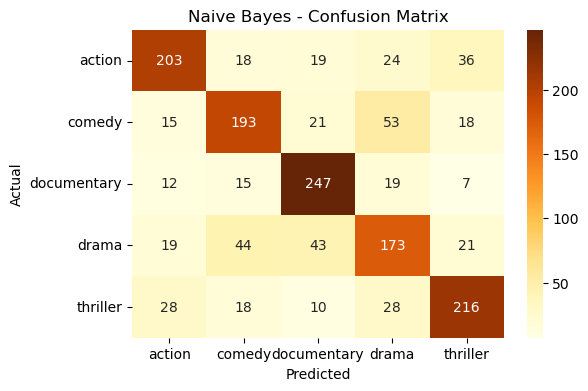

In [143]:
# --- NAIVE BAYES ---

print("🟡 Naive Bayes")

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, scoring='f1_weighted', cv=5)
grid_nb.fit(X_train_sel, y_train)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_sel)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "YlOrBr", label_encoder.classes_)


In [145]:
print("\n📊 Model F1 Score Comparison")
print(f"Logistic Regression: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"Random Forest     : {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Naive Bayes       : {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")



📊 Model F1 Score Comparison
Logistic Regression: 0.6994
Random Forest     : 0.6429
Naive Bayes       : 0.6868


# TFIDF MODELLING

In [184]:
vectorizer = TfidfVectorizer(max_df=0.16, max_features=5000)
tfidf_X = vectorizer.fit_transform(description_string)
tfidf_X_vectorized = tfidf_X.toarray()

In [164]:
print(tfidf_X_vectorized.max())

1.0


In [178]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.76      0.75       409
      comedy       0.67      0.65      0.66       418
 documentary       0.76      0.81      0.78       402
       drama       0.57      0.56      0.57       388
    thriller       0.74      0.71      0.72       383

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

🎯 Weighted F1 Score: 0.6976


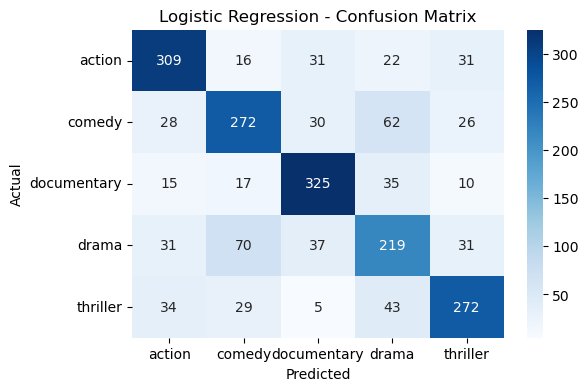

In [175]:
print("🔵 Logistic Regression")

model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)


🟣 Naive Bayes
              precision    recall  f1-score   support

      action       0.72      0.74      0.73       409
      comedy       0.75      0.52      0.62       418
 documentary       0.75      0.81      0.78       402
       drama       0.56      0.62      0.59       388
    thriller       0.69      0.75      0.72       383

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

🎯 Weighted F1 Score: 0.6861


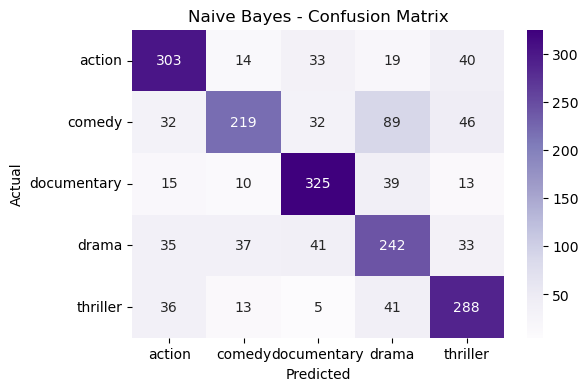

In [176]:
print("🟣 Naive Bayes")

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "Purples", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.69      0.67       409
      comedy       0.64      0.46      0.54       418
 documentary       0.72      0.78      0.75       402
       drama       0.47      0.54      0.51       388
    thriller       0.67      0.66      0.67       383

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

🎯 Weighted F1 Score: 0.6254


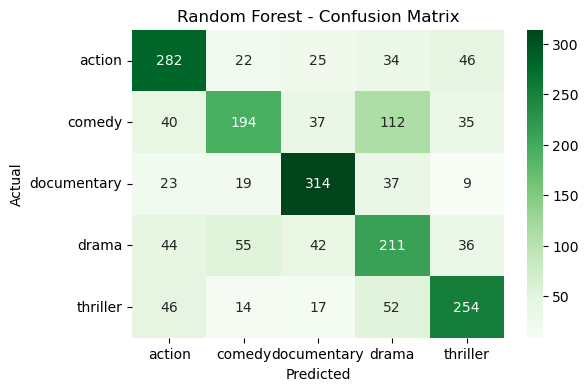

In [177]:
print("🟢 Random Forest")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)

# AFTER TRAINING TFIDF

In [181]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)


selector = SelectKBest(chi2, k=3900)
X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
X_test_sel = selector.transform(X_test_tfidf)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [182]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'solver': ['liblinear', 'lbfgs'],   # Optimization solver
    'penalty': ['l2']                   # Regularization type (lbfgs only supports 'l2')
}

# Create the model
lr = LogisticRegression(max_iter=1000)

# Grid search using weighted F1 score and 5-fold CV
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, 
                       scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

# Fit the model using selected features (after SelectKBest)
grid_lr.fit(X_train_sel, y_train)

# Best model and predictions
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

# Results
print("🔵 Best Logistic Regression Parameters:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Best Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
🔵 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

      action       0.75      0.72      0.74       316
      comedy       0.67      0.66      0.66       309
 documentary       0.74      0.83      0.79       284
       drama       0.61      0.60      0.60       301
    thriller       0.75      0.72      0.73       290

    accuracy                           0.70      1500
   macro avg       0.70      0.71      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Best Weighted F1 Score: 0.7038
